In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

In [11]:
def y2indicator(Y, K=10):
    # K=10 for MNIST
    # Python
    N = len(Y)
    Y = Y.astype(np.int32)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, Y[i]] = 1
    return ind
    
def get_normalized_data():
    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    Y = data[:,0]
    X = data[:,1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std==0, 1)
    X = (X-mu)/std
    return X, Y

def error(p, t):
    return np.mean(p != t)

In [12]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = np.sqrt(in_dim/2.0)
    return np.random.randn(size[0],size[1]) / xavier_stddev

def NN(X, W1, b1, W2, b2):
    Z = T.nnet.nnet.relu( X.dot(W1)+b1 )
    Y = T.nnet.nnet.softmax( Z.dot(W2)+b2 )
    return Y, Z

In [13]:
# Input
X, Y = get_normalized_data()
Xtrain = X[:-1000,]                                                         
Ytrain = Y[:-1000]                                                          
Xtest  = X[-1000:,]                                                         
Ytest  = Y[-1000:]                                                          
Ytrain_ind = y2indicator(Ytrain)                                            
Ytest_ind = y2indicator(Ytest)

# Parameters
lr = 1.0e-5
reg = 1.0e-2
N, D = Xtrain.shape
M = 300
K=10

max_iter = 100
print_period = 10
batch_size = 500
n_batches = N//batch_size

In [16]:
thX = T.matrix('X')
thT = T.matrix('T')


W1_init = xavier_init([D, M])
b1_init = np.zeros(M)
W2_init = xavier_init([M, K])
b2_init = np.zeros(K)
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')



thY, thZ = NN(thX, W1, b1, W2, b2)
    
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())

prediction = T.argmax(thY, axis=1)



update_W1 = W1 - lr*T.grad(cost, W1)
update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
update_b2 = b2 - lr*T.grad(cost, b2)

train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)],
)
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

In [17]:
costs = []
for i in range(max_iter):
    for j in range(n_batches):
        batch_range = (j*batch_size, j*batch_size + batch_size)
        
        Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
        Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]            
        
        train(Xbatch, Ybatch)
    if i % print_period == 0:
        cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
        err = error(prediction_val, Ytest)
        print('Cost/Err: {} / {}'.format(cost_val, err))
        costs.append( cost_val )

Cost/Err: 1239.2636417479657 / 0.35
Cost/Err: 412.65112396607253 / 0.106
Cost/Err: 338.697387783846 / 0.081
Cost/Err: 304.38649945738774 / 0.068
Cost/Err: 283.0975381949457 / 0.06
Cost/Err: 267.87365399124883 / 0.054
Cost/Err: 256.2571643415792 / 0.049
Cost/Err: 247.061045387072 / 0.047
Cost/Err: 239.56518553375983 / 0.044
Cost/Err: 233.318677293513 / 0.045


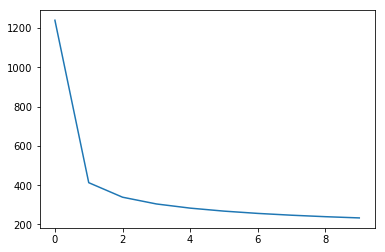

In [18]:
plt.plot(costs)
plt.show()